In [1]:
%matplotlib inline
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import tensorflow as tf 
tf.set_random_seed(22)
from keras.backend.tensorflow_backend import set_session 
config = tf.ConfigProto() 
config.gpu_options.per_process_gpu_memory_fraction = 0.8
set_session(tf.Session(config = config))
import pandas as pd
import wfdb
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
# Good beats from Physionet beats annotation guidlines
good_beats = ['N', 'L', 'R', 'B', 'A', 'a', 'J', 'S', 'V', 'r',
        'F', 'e', 'j', 'n', 'E', '/', 'f', 'Q', '?']

### Beat extraction

In [3]:
twoch_df = pd.DataFrame()
firstch_df = pd.DataFrame()

# 120 samples to the left and right from the beat label 
half_qrs=120

for filename in os.listdir('mitdb'):
    # Exclusion of some datasets
    if filename.endswith(".dat") and not filename.startswith(('102','104','107','217')):
        ann = wfdb.rdann('mitdb/' + filename.strip('.dat'), 'atr')
        record = wfdb.rdsamp('mitdb/' + filename.strip('.dat'))
        
        # We want just the signals
        data = record[0]
        
        # Prepare containers
        signals, classes = [], []
        firstch_signals = []
        firstch_class = []
        
        # Beat extraction
        for it, beat in enumerate(ann.symbol):
            if beat in good_beats:
                
                sta = ann.sample[it] - half_qrs
                end = ann.sample[it] + half_qrs
                qrs = data[sta : end, :]
            
                # This may happen at the edges
                if len(qrs) != 2 * half_qrs: continue
                
                # Extracting only first channel signals and classes 
                firstch_beat_class = '{}_{}'.format(record[1]['sig_name'][0], beat)
                firstch_signals.append(qrs[:,0].reshape(240,))
                firstch_class.append(firstch_beat_class)
            
                # Keep the channel type in the class name (both channels)
                for ch in range(2):
                    beat_class = '{}_{}'.format(record[1]['sig_name'][ch], beat)
                    signals.append(qrs[:, ch].reshape(240,))
                    classes.append(beat_class)
                
        new_frame = pd.DataFrame({'qrs_data' : signals,
                              'qrs_type' : classes})
        
        new_frame_firstch = pd.DataFrame({'qrs_data' : firstch_signals,
                              'qrs_type' : firstch_class})
        # Cumulate
        twoch_df = twoch_df.append(new_frame)
        firstch_df = firstch_df.append(new_frame_firstch)

### Preparation of datasets

In [4]:
training = pd.DataFrame()

# We extract 120 samples to the left and right from the beat label. Total: 240 samples per beat
half_qrs=120

for filename in os.listdir('mitdb'):
    if filename.endswith(".dat"):
        ann = wfdb.rdann('mitdb/' + filename.strip('.dat'), 'atr')
        record = wfdb.rdsamp('mitdb/' + filename.strip('.dat'))
        
        # Signals are stored in position 0 of record
        data = record[0]
        
        # Prepare containers
        signals, classes = [], []
        
        # Beat extraction
        for it, beat in enumerate(ann.symbol):
            if beat in good_beats:
                
                sta = ann.sample[it] - half_qrs
                end = ann.sample[it] + half_qrs
                qrs = data[sta : end, :]
            
                # This may happen at the edges
                if len(qrs) != 2 * half_qrs: continue
                
                # Extracting only first channel signals and classes 
                beat_class = '{}_{}'.format(record[1]['sig_name'][0], beat)
                signals.append(qrs[:,0].reshape(240,))
                classes.append(beat_class)
                
        frame = pd.DataFrame({'beat' : signals,
                              'label' : classes})

        # Append
        training = training.append(frame)

In [5]:
training.shape

(109459, 2)

In [6]:
training['label'].value_counts()

MLII_N    72945
MLII_L     8071
MLII_R     7257
MLII_V     7080
MLII_/     3619
V5_/       3407
MLII_A     2536
V5_N       2082
MLII_F      798
V5_f        722
MLII_f      260
MLII_j      229
MLII_a      150
MLII_E      106
MLII_J       81
V5_V         49
V5_Q         18
MLII_e       16
MLII_Q       15
V5_A         10
V5_F          4
MLII_S        2
V5_J          2
Name: label, dtype: int64

In [7]:
# Exclude all classes except N, L, R, V, A

training = training[training['label']!='V5_J']
training = training[training['label']!='MLII_S']
training = training[training['label']!='V5_F']
training = training[training['label']!='V5_A']
training = training[training['label']!='MLII_Q']
training = training[training['label']!='MLII_e']
training = training[training['label']!='V5_Q']
training = training[training['label']!='V5_V']
training = training[training['label']!='MLII_J']
training = training[training['label']!='MLII_E']
training = training[training['label']!='MLII_a']
training = training[training['label']!='MLII_j']
training = training[training['label']!='MLII_f']
training = training[training['label']!='V5_f']
training = training[training['label']!='MLII_F']
training = training[training['label']!='V5_N']
training = training[training['label']!='V5_/']
training = training[training['label']!='MLII_/']



training['label'].value_counts()

MLII_N    72945
MLII_L     8071
MLII_R     7257
MLII_V     7080
MLII_A     2536
Name: label, dtype: int64

In [8]:
training_labels = training['label'].values

#### We take 2000 beats from each class for train autoencoders' datasets

In [9]:
autoenc_train = pd.DataFrame()
firstch_classes = pd.DataFrame(firstch_df['qrs_type'].value_counts())

for row in firstch_classes.itertuples():
    if row[0] in ['MLII_N', 'MLII_L', 'MLII_R', 'MLII_V', 'MLII_A']:
        autoenc_train = autoenc_train.append(firstch_df[firstch_df['qrs_type']==row[0]].iloc[:2000,:])

In [10]:
autoenc_train_labels = autoenc_train['qrs_type'].values

In [11]:
autoenc_train = np.vstack(autoenc_train['qrs_data']).reshape(10000,240,1)

## Autoencoder

In [12]:
import keras
from keras.layers import Layer, Input,Conv1D,MaxPooling1D,UpSampling1D, Flatten, Dense, Reshape
from keras.models import Model
from keras.optimizers import RMSprop, Nadam
import keras.models as models
from keras import backend as K
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import Dropout
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
from keras.utils import plot_model
from sklearn.model_selection import train_test_split
import random
import matplotlib as mpl
import matplotlib.cm as cm

In [13]:
# Hyperparameters
batch_size = 25
epochs = 20
input_sig = Input(shape = (240,1))

In [14]:
def conv_autoencoder(input_sig):
    
    # Part 1: Encoder
    conv1 = Conv1D(30, 3, activation='relu', padding='same')(input_sig)
    pool1 = MaxPooling1D(2)(conv1)
    conv2 = Conv1D(60, 3, activation='relu', padding='same')(pool1)
    pool2 = MaxPooling1D(2)(conv2)
    flat = Flatten()(pool2)
    dense1 = Dense(25)(flat)
    dense2 = Dense(10)(dense1) #15
                         
    # Part 2: Decoder
    dense3 = Dense(25)(dense2)
    dense4 = Dense(60*60)(dense3)
    reshape = Reshape((60,60))(dense4)
    up1 = UpSampling1D(2)(reshape)
    conv5 = Conv1D(30, 3, activation='relu', padding='same')(up1)
    up2 = UpSampling1D(2)(conv5) 
    decoded = Conv1D(1, 3, activation='relu', padding='same')(up2)
    return decoded

In [34]:
autoencoder = Model(input_sig, conv_autoencoder(input_sig))
autoencoder.compile(loss='mean_squared_error', optimizer = Nadam())

In [35]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 240, 1)            0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 240, 30)           120       
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 120, 30)           0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 120, 60)           5460      
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 60, 60)            0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 3600)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 25)                90025     
__________

In [36]:
train_X,valid_X,train_ground,valid_ground = train_test_split(autoenc_train,
                                                             autoenc_train, 
                                                             test_size=0.3, 
                                                             random_state=13)

In [37]:
autoencoder_train = autoencoder.fit(train_X, train_ground, batch_size=batch_size,epochs=epochs,verbose=1,
                                    validation_data=(valid_X, valid_ground))

Train on 7000 samples, validate on 3000 samples
Epoch 1/20
7000/7000 [==============================] - 6s 848us/step - loss: 0.2346 - val_loss: 0.2373
Epoch 2/20
7000/7000 [==============================] - 5s 734us/step - loss: 0.2295 - val_loss: 0.2369
Epoch 3/20
7000/7000 [==============================] - 5s 733us/step - loss: 0.2294 - val_loss: 0.2368
Epoch 4/20
7000/7000 [==============================] - 5s 739us/step - loss: 0.2288 - val_loss: 0.2360
Epoch 5/20
7000/7000 [==============================] - 5s 735us/step - loss: 0.2288 - val_loss: 0.2361
Epoch 6/20
7000/7000 [==============================] - 5s 741us/step - loss: 0.2282 - val_loss: 0.2369
Epoch 7/20
7000/7000 [==============================] - 5s 747us/step - loss: 0.2282 - val_loss: 0.2355
Epoch 8/20
7000/7000 [==============================] - 5s 741us/step - loss: 0.2280 - val_loss: 0.2365
Epoch 9/20
7000/7000 [==============================] - 5s 751us/step - loss: 0.2285 - val_loss: 0.2359
Epoch 10/20
7000

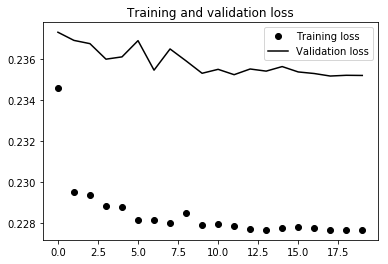

In [38]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
plt_epochs = range(epochs)
plt.figure()
plt.plot(plt_epochs, loss, 'ko', label='Training loss')
plt.plot(plt_epochs, val_loss, 'k', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### Test how it is the output of a segment of every type

Correlation N
 [[1.         0.98769604]
 [0.98769604 1.        ]]
Correlation L
 [[1.         0.89279734]
 [0.89279734 1.        ]]
Correlation R
 [[1.         0.96033074]
 [0.96033074 1.        ]]
Correlation V
 [[1.         0.93428237]
 [0.93428237 1.        ]]
Correlation A
 [[1.         0.91699909]
 [0.91699909 1.        ]]


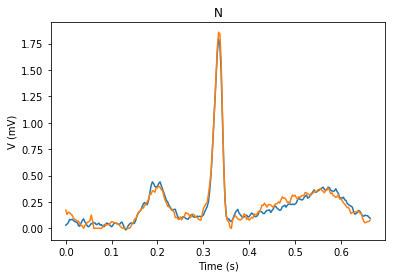

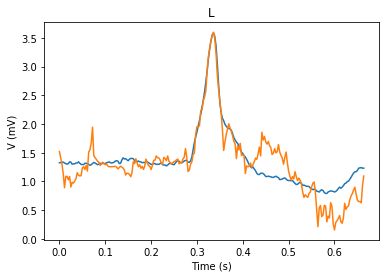

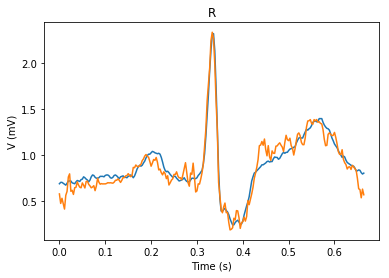

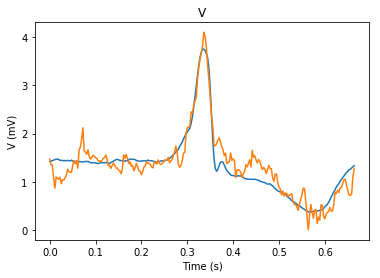

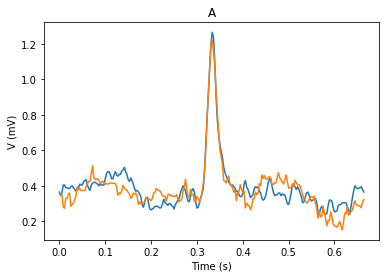

In [72]:
# Input vs Output of the autoencoder
convout1_f = K.function([autoencoder.input], [autoencoder.layers[14].output])
C1 = convout1_f([autoenc_train[autoenc_train_labels=='MLII_N']])[0] #N, L, R, V, A
C1 = np.squeeze(C1[0])
C1.shape
C2 = convout1_f([autoenc_train[autoenc_train_labels=='MLII_L']+1.5])[0] #N, L, R, V, A
C2 = np.squeeze(C2[0])
C2.shape
C3 = convout1_f([autoenc_train[autoenc_train_labels=='MLII_R']+1])[0] #N, L, R, V, A
C3 = np.squeeze(C3[0])
C3.shape
C4 = convout1_f([autoenc_train[autoenc_train_labels=='MLII_V']+2])[0] #N, L, R, V, A
C4 = np.squeeze(C4[0])
C4.shape
C5 = convout1_f([autoenc_train[autoenc_train_labels=='MLII_A']+0.5])[0] #N, L, R, V, A
C5 = np.squeeze(C5[0])
C5.shape

# Build X vector
x=np.arange(240)
x=x/360

# Plot
fig1, ax1 = plt.subplots()
ax1.set_title("N")
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('V (mV)')
C01 = autoenc_train[autoenc_train_labels=='MLII_N'][0]
C01 = C01.flatten()
ax1.plot(x, C01)
ax1.plot(x, C1)
corrcoefN = np.corrcoef(C01,C1)
print('Correlation N\n', corrcoefN)

fig2, ax2 = plt.subplots()
ax2.set_title("L")
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('V (mV)')
C02 = autoenc_train[autoenc_train_labels=='MLII_L'][0]+1.5
C02 = C02.flatten()
ax2.plot(x, C02)
ax2.plot(x, C2)
corrcoefL = np.corrcoef(C02,C2)
print('Correlation L\n', corrcoefL)


fig3, ax3 = plt.subplots()
ax3.set_title("R")
ax3.set_xlabel('Time (s)')
ax3.set_ylabel('V (mV)')
C03 = autoenc_train[autoenc_train_labels=='MLII_R'][0]+1
C03 = C03.flatten()
ax3.plot(x, C03)
ax3.plot(x, C3)
corrcoefR = np.corrcoef(C03,C3)
print('Correlation R\n', corrcoefR)

fig4, ax4 = plt.subplots()
ax4.set_title("V")
ax4.set_xlabel('Time (s)')
ax4.set_ylabel('V (mV)')
C04 = autoenc_train[autoenc_train_labels=='MLII_V'][0]+2
C04 = C04.flatten()
ax4.plot(x, C04)
ax4.plot(x, C4)
corrcoefV = np.corrcoef(C04,C4)
print('Correlation V\n', corrcoefV)

fig5, ax5 = plt.subplots()
ax5.set_title("A")
ax5.set_xlabel('Time (s)')
ax5.set_ylabel('V (mV)')
C05 = autoenc_train[autoenc_train_labels=='MLII_A'][0]+0.5
C05 = C05.flatten()
ax5.plot(x, C05)
ax5.plot(x, C5)
corrcoefA = np.corrcoef(C05,C5)
print('Correlation A\n', corrcoefA)



## Visualization

In [72]:
def create_encoding_layers():
    return [
     Conv1D(30, 3, activation='relu', padding='same'),
     MaxPooling1D(2),
     Conv1D(60, 3, activation='relu', padding='same'),
     MaxPooling1D(2),
     Flatten(),
     Dense(25),
     Dense(10), #15
    ]

In [73]:
# Build an encoder-only by copying the weights
encoder = models.Sequential()
encoder.add(Layer(input_shape=(240,1)))
encoding_layers = create_encoding_layers()
for l in encoding_layers:
    encoder.add(l)
encode = K.function([encoder.input], [encoder.output])

In [74]:
train_repr = encode([autoenc_train])[0] #it was not train, but it was test, changed to avoid error

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7fab64e329b0>>
Traceback (most recent call last):
  File "/home/miguel/.local/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/home/miguel/.local/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.InvalidArgumentError: No such callable handle: 124958832


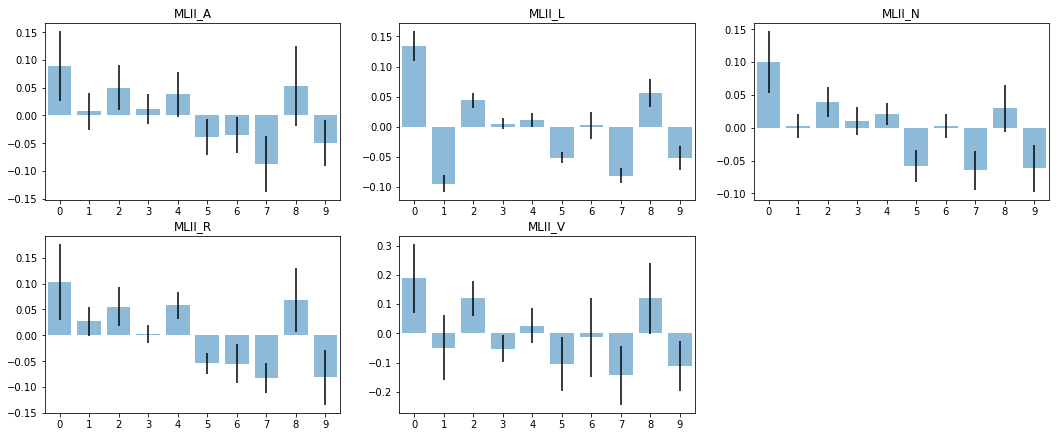

In [75]:
plt.figure(figsize=(18,15))

for i,label in enumerate(np.unique(autoenc_train_labels)): #it was not train, but it was test, changed to avoid error
    plt.subplot(4, 3, i + 1)
    plt.title(label)
    encodings = train_repr[autoenc_train_labels == label] #it was not train, but it was test, changed to avoid error
    
    means = np.mean(encodings, axis=0)
    stds = np.std(encodings, axis=0)
    
    bar_centers = np.arange(train_repr.shape[1])
    plt.bar(bar_centers, means, width=0.8, align='center', yerr=stds, alpha=0.5)
    plt.xticks(bar_centers, bar_centers)
    plt.xlim((-0.5, bar_centers[-1] + 0.5))